In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# IMPORTANT: Replace 'telecom_customer_churn.csv' with the actual path to your file
df = pd.read_csv('telecom_customer_churn.csv')

# 1. Preview the data
print("First 5 rows of data:")
display(df.head())

# 2. Data Cleaning: 'TotalCharges' is read as object (string) but should be numeric
# 'coerce' turns non-numeric values (like empty strings) into NaN (Not a Number)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for null values created by the conversion
print(f"\nMissing values in TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Fill missing values with 0 (assuming tenure is 0 for these customers)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Drop 'customerID' as it is unique and not useful for prediction
df.drop(columns=['customerID'], inplace=True)

# Convert Churn 'Yes'/'No' to 1/0 for analysis
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("\nData loaded and cleaned successfully.")

First 5 rows of data:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Missing values in TotalCharges: 11

Data loaded and cleaned successfully.


C:\Users\Harshada\AppData\Local\Temp\ipykernel_8296\2853732420.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='pastel')


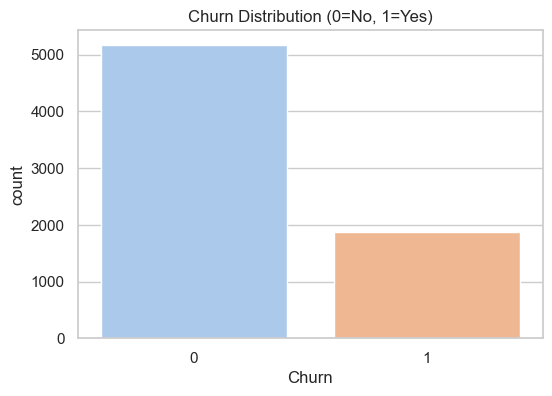

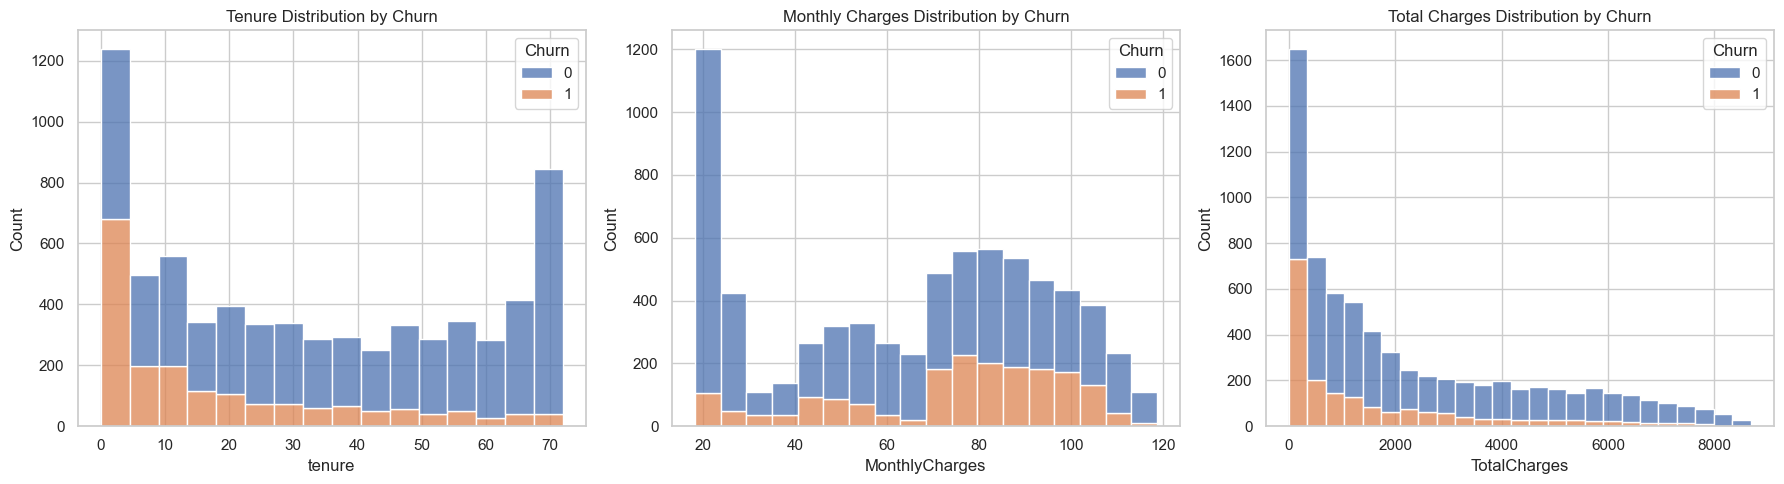

In [5]:
# Set visualization style
sns.set(style="whitegrid")

# 1. Visualize the Target Variable (Churn)
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='pastel')
plt.title('Churn Distribution (0=No, 1=Yes)')
plt.show()

# 2. Visualize Numeric Features vs Churn
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Tenure vs Churn
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', ax=axes[0])
axes[0].set_title('Tenure Distribution by Churn')

# MonthlyCharges vs Churn
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', ax=axes[1])
axes[1].set_title('Monthly Charges Distribution by Churn')

# TotalCharges vs Churn
sns.histplot(data=df, x='TotalCharges', hue='Churn', multiple='stack', ax=axes[2])
axes[2].set_title('Total Charges Distribution by Churn')

plt.tight_layout()
plt.show()

# Insight: New customers (low tenure) and high monthly charges seem to churn more.

In [6]:
from sklearn.model_selection import train_test_split

# 1. Convert Categorical variables to Dummy variables (One-Hot Encoding)
# drop_first=True avoids multicollinearity (dummy variable trap)
df_encoded = pd.get_dummies(df, drop_first=True)

# 2. Define Features (X) and Target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# 3. Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (5634, 30)
Testing shape: (1409, 30)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Scale data for Logistic Regression (important for convergence)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Dictionary to store results
results = {}

# Train Models
print("Training models...")
for name, model in models.items():
    # Use scaled data for Logistic Regression, regular data for trees
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        "predictions": preds,
        "probabilities": probs,
        "model_obj": model
    }
    print(f"{name} trained.")

Training models...
Logistic Regression trained.
Random Forest trained.
XGBoost trained.


C:\Users\Harshada\anaconda3\Lib\site-packages\xgboost\training.py:200: UserWarning: [23:32:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\Harshada\AppData\Local\Temp\ipykernel_8296\430540916.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, new_row], ignore_index=True)


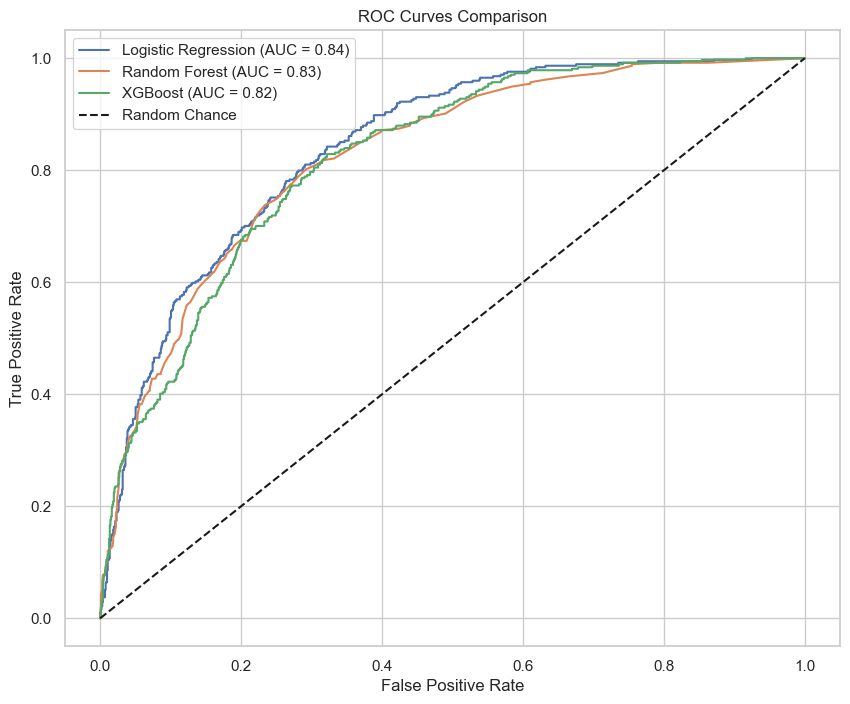


Model Performance Metrics:


,Model,Accuracy,Recall,ROC-AUC
0,Logistic Regression,0.806955,0.566845,0.841778
1,Random Forest,0.784954,0.497326,0.825331
2,XGBoost,0.772179,0.497326,0.822384


In [8]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

# Create a DataFrame to compare metrics
performance_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'ROC-AUC'])

plt.figure(figsize=(10, 8))

for name, res in results.items():
    y_pred = res['predictions']
    y_prob = res['probabilities']
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    # Add to performance table (using pd.concat instead of append)
    new_row = pd.DataFrame({'Model': [name], 'Accuracy': [acc], 'Recall': [rec], 'ROC-AUC': [roc]})
    performance_df = pd.concat([performance_df, new_row], ignore_index=True)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc:.2f})')

# Finalize Plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Display Metrics Table
print("\nModel Performance Metrics:")
display(performance_df)

C:\Users\Harshada\AppData\Local\Temp\ipykernel_8296\2910825092.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


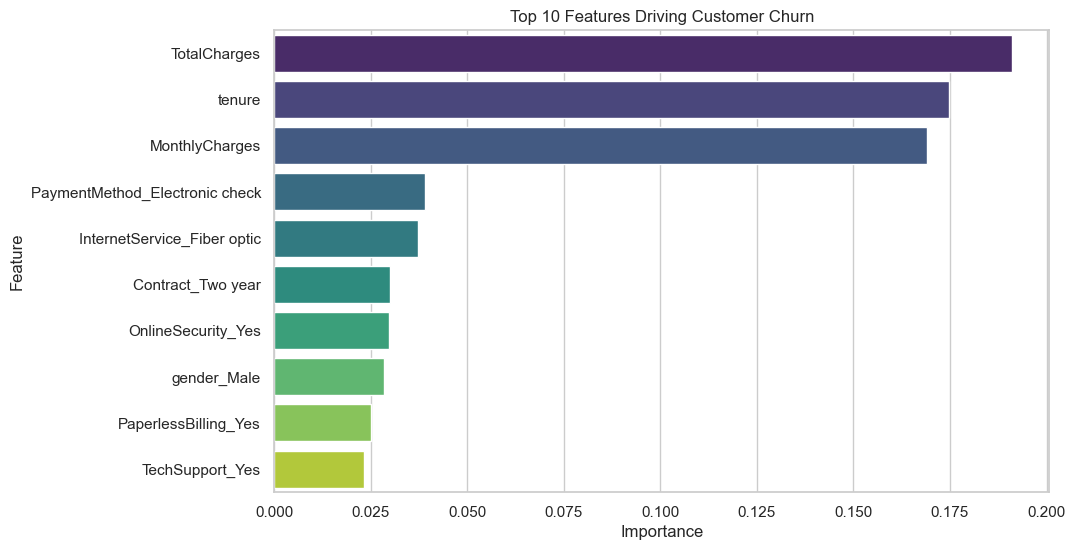

In [9]:
# Extract feature importance from the Random Forest model
importances = models["Random Forest"].feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Features Driving Customer Churn')
plt.show()